In [21]:
from pathlib import Path
import patato as pat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from paiskintonetools import setup_matplotlib

from paiskintonetools.correction_factor import get_correction_factor_interpolator

setup_matplotlib(300)

In [22]:
unmixer = pat.SpectralUnmixer(
    chromophores=["Hb", "HbO2"], wavelengths=[700.0, 730.0, 760.0, 800.0, 850.0]
)
correct = False


correction_factor_spline = get_correction_factor_interpolator(
    "../Fluence Correction/cali_curve.csv"
)

df_scans = pd.read_parquet("../01_Prepare Data/scan_table.parquet")
df_scans = df_scans.query("SkinID=='SKIN36' and Region=='Carotid Artery'").set_index(
    "ScanNumber"
)[["ITA"]]

In [23]:
# wavelength = np.linspace(700, 900)
# mvf = np.logspace(np.log10(0.02), np.log10(0.4), 6)
# for i in mvf:
#     plt.plot(wavelength, np.exp(-correction_factor_spline((wavelength, i))))
# plt.show()

In [24]:
import json

settings = json.load(open("../data_paths.json", "r"))
root_data_path = (Path.cwd() / "../" / settings["vitiligo_data_path"]).resolve()

data_folder = root_data_path / "SKIN36"
measurements = defaultdict(list)
measurements_corrected = defaultdict(list)

for f in data_folder.glob("*.hdf5"):
    pa = pat.PAData.from_hdf5(f)
    scan_number = int(f.stem.split("_")[-1])
    pa.set_default_recon(("Model Based", "0"))
    if scan_number not in df_scans.index:
        pa.scan_reader.file.close()
        continue
    ita = df_scans.loc[scan_number, "ITA"]
    if ("skin_", "0") not in pa.get_rois():
        pa.scan_reader.file.close()
        continue
    else:
        r = pa.get_rois()["skin_", "0"]
        rec = pa.get_scan_reconstructions()
        rec.raw_data = np.array(rec.raw_data)

        mask, _ = r.to_mask_slice(rec)

        mask[np.any(rec.raw_data[0, :4] < 0, axis=0)] = False

        thb = rec.raw_data[0, 0]
        print(thb.shape, mask.shape)

        measurements[pa.get_scan_name().split("-")[1]].append(np.mean(thb[mask]))

(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)
(400, 1, 400) (400, 1, 400)


In [25]:
df_scans

,ITA
ScanNumber,
21,26.936667
22,26.936667
23,26.936667
18,1.090000
19,1.090000
20,1.090000


In [26]:
measurements

defaultdict(list,
            {'pigment': [0.01734499257299372,
              0.023893044580193572,
              0.026680720977862563],
             'nopigment': [0.008521532530505927,
              0.00701973197671584,
              0.008240745717741275]})

In [27]:
dfs = [pd.DataFrame(x) for x in [measurements]]
df = pd.concat(dfs, axis=1)

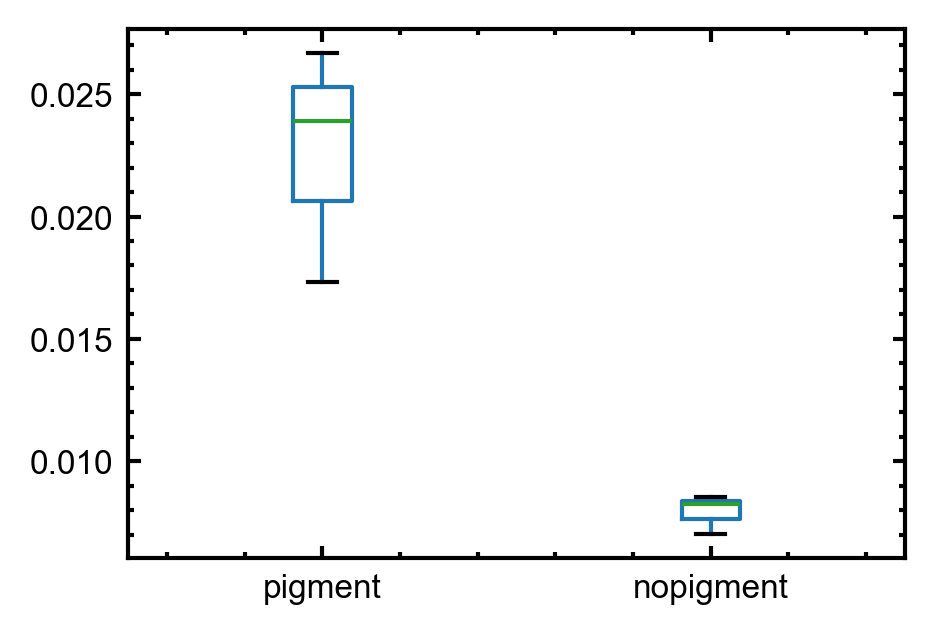

In [28]:
df.boxplot(grid=False, figsize=(3, 2), meanline=True)
# plt.plot([1, 2], [0.875+3.196/100, 0.875], c="C1")
plt.show()

In [29]:
m = dfs[0].mean()
s = dfs[0].std() / np.sqrt(3)
display(m)
display(s)

pigment      0.022640
nopigment    0.007927
dtype: float64

pigment      0.002767
nopigment    0.000461
dtype: float64

In [30]:
print(ttest_ind(dfs[0]["pigment"], dfs[0]["nopigment"]))

TtestResult(statistic=5.244923109820364, pvalue=0.00631901782561806, df=4.0)


In [31]:
delta = m["pigment"] - m["nopigment"]
uncertainty = np.linalg.norm(s)

print(f"{delta:.2f}±{uncertainty:.2f}")

0.01±0.00


In [32]:
predicted = 3.196
np.abs((predicted - delta) / uncertainty)

1134.1304310499386